<span class='note'><i>Make me look good.</i> Click on the cell below and press <kbd>Ctrl</kbd>+<kbd>Enter</kbd>.</span>

In [1]:
from IPython.core.display import HTML
HTML(open('css/custom.css', 'r').read())

<h5 class='prehead'>SM286D &middot; Introduction to Applied Mathematics with Python &middot; Spring 2020 &middot; Uhan</h5>

<h5 class='lesson'>Lesson 19.</h5>

<h1 class='lesson_title'>More data visualization</h1>

## This lesson...

In this lesson, we'll walk through the inner workings of an SMO capstone project by MIDN 1/C Arvin, MIDN 1/C Kugel, MIDN 1/C Urrutia, and MIDN 1/C Villacorta (Class of 2020).  

The goal of this lesson is three-fold:

- See an example of how to visualize the output of an optimization model in a user-friendly way.

- See more examples of Pyomo and Cartopy in action.

- See an example of a *real* capstone project that tries to solve an actual Navy problem.

As you'll see, all the Python programming for this project is well within your grasp, based on the programming knowledge you gained this semester! You'll learn about some of the more advanced mathematical methods in future courses.

## Problem description

The goal of their project was to help NAVAIR determine the optimal locations for different types of 3D printers for a given budget.   They formulated a facility location model that is described below.  You'll cover the details of how to model this type of problem in SA405 &mdash; Advanced Mathematical Programming. For this lesson, we'll focus on visualizing the output of the optimization model. 

First, look over the problem statement and assumptions below.  

Given a list of customer locations, which can also serve as locations for 3D printers, and a fixed budget, determine locations for the printers that minimize overall cost.  We make the following assumptions:

 - There are 23 possible customer locations in the continental US.
 - There are two tiers of 3D printers, tier 1 and tier 2.
 - It is possible to place between 0 and 30 printers at any given location.
 - The demands for customer locations were determined based on data from NAVAIR.
 - There is a penalty to be paid if demand can't be satisfied for a given customer location.
 - Shipping costs were determined based on FedEx shipping rates.
 - There is a uniform one-time charge to purchase tier 1 or tier 2 printers. These were determined based on market research.  
 - There is a one-time start-up cost if any 3D printers are introduced at a particular location. 
 - 3D printers have a maximum capacity to print parts, and can only print parts corresponding to their respective tier.
 - The distance between possible printer locations are based on the straight line distance between their latitudes and longitudes.
 - The total budget is a fixed dollar amount.

Based on these assumptions, the model formulation is given below.  Look it over, and then read the description below.

__Indices and sets.__

\begin{array}{ll}
  i \in I & \mbox{customers}, I = \{1, 2, \dots, 23\}                                        \\
  j \in J & \mbox{possible printer locations}, J = \{1, 2, ..., 23\}                         \\
  p \in P & \mbox{possible number of printers at a given location}, P = \{0, 1, 2, ..., 30\} \\
\end{array}

__Data.__

\begin{array}{ll}
  \mathit{demand1}_i        & \mbox{tier 1 customer demand at node $i$}                                        \\
  \mathit{demand2}_i        & \mbox{tier 2 customer demand at node $i$}                                        \\
  \mathit{penalty1}         & \mbox{penalty for not satisfying tier 1 demands}                                 \\
  \mathit{penalty2}         & \mbox{penalty for not satisfying tier 2 demands}                                 \\
  \beta                     & \mbox{proportionality constant for shipping costs}                               \\
  \mathit{f1}_{j}           & \mbox{one-time fixed cost for a tier 1 printer at location $j$}                  \\
  \mathit{f2}_{j}           & \mbox{one-time fixed cost for a tier 2 printer at location $j$}                  \\
  \mathit{start\_cost1}_{j} & \mbox{start-up cost associated with putting any tier 1 printers at location $j$} \\
  \mathit{start\_cost2}_{j} & \mbox{start-up cost associated with putting any tier 2 printers at location $j$} \\
  \mathit{cap1}_j           & \mbox{capacity of a tier 1 printer at location $j$}                              \\
  \mathit{cap2}_j           & \mbox{capacity of a tier 2 printer at location $j$}                              \\
  \mathit{dist}_{ij}        & \mbox{length of shortest path between customer $i$ and printer location $j$}     \\
  \mathit{budget}           & \mbox{total amount of money available}                                           \\
  \mathit{M}                & \mbox{big enough integer value (set by the length of $P$)}                       \\
\end{array}

__Decision variables.__

\begin{array}{ll}
  \mathit{FRACUN1}_i  & \mbox{fraction of tier 1 customer $i$ demand unfulfilled}                       \\
  \mathit{FRACUN2}_i  & \mbox{fraction of tier 2 customer $i$ demand unfulfilled}                       \\
  \mathit{OPEN1}_{jp} & \mbox{1 if $p$ tier 1 printers are located at $j$, 0 otherwise}                 \\
  \mathit{OPEN2}_{jp} & \mbox{1 if $p$ tier 2 printers are located at $j$, 0 otherwise}                 \\
  \mathit{SAT1}_{ij}  & \mbox{fraction of tier 1 customer $i$ demand satisfied by printer location $j$} \\
  \mathit{SAT2}_{ij}  & \mbox{fraction of tier 2 customer $i$ demand satisfied by printer location $j$} \\
  \mathit{NOT0P1}_j   & \mbox{1 if any tier 1 printers open at location $j$, 0 otherwise}               \\
  \mathit{NOT0P2}_j   & \mbox{1 if any tier 2 printers open at location $j$, 0 otherwise}               \\
\end{array}

__Formulation.__

\begin{alignat}{4}
  \min \quad & \sum_{j \in J, p \in P} p \cdot f1_{j} \mathit{OPEN1}_{jp} + \sum_{j \in J, p \in P} p \cdot f2_{j} \mathit{OPEN2}_{jp} \\
  & \qquad + \beta \sum_{i \in I, j \in J} \mathit{demand1}_i dist_{ij} \mathit{SAT1}_{ij} + \beta \sum_{i \in I, j \in J} \mathit{demand2}_i \mathit{dist}_{ij} \mathit{SAT2}_{ij} \\
  & \qquad + \sum_{i \in I} \mathit{penalty1} \mathit{demand1}_i \mathit{FRACUN1}_i + \sum_{i \in I} \mathit{penalty2} \mathit{demand2}_i \mathit{FRACUN2}_i\\
  & \qquad + \sum_{j \in J} \mathit{start\_cost1}_{j} \mathit{NOT0P1}_{j} + \sum_{j \in J} \mathit{start\_cost2}_{j} \mathit{NOT0P2}_{j} \\
  \mbox{s.t.} \quad & \sum_{j \in J, p \in P} p \cdot f1_{j} \mathit{OPEN1}_{jp} + \sum_{j \in J, p \in P} p \cdot f2_{j} \mathit{OPEN2}_{jp}                           \\
                    & \qquad + \sum_{j \in J} \mathit{start\_cost1}_{j} \mathit{NOT0P1}_{j} + \sum_{j \in J} \mathit{start\_cost2}_{j} \mathit{NOT0P2}_{j} \le \mathit{budget}  & \qquad &                          & \quad (1)  \\
                    & \mathit{FRACUN1}_{i} + \sum_{j\in J} \mathit{SAT1}_{ij} = 1                                                                                        & \qquad & \forall i \in I          & \quad (2)  \\
                    & \mathit{FRACUN2}_{i} + \sum_{j\in J} \mathit{SAT2}_{ij} = 1                                                                                        & \qquad & \forall i \in I          & \quad (3)  \\
                    & \sum_{p \in P} \mathit{OPEN1}_{jp} = 1                                                                                                             &        & \forall j \in J          & \quad (4)  \\
                    & \sum_{p \in P} \mathit{OPEN2}_{jp} = 1                                                                                                             &        & \forall j \in J          & \quad (5)  \\
                    & \sum_{p \in P} p \cdot \mathit{OPEN1}_{jp} \le M \mathit{NOT0P1}_j                                                                                 &        & \forall j \in J          & \quad (6)  \\
                    & \sum_{p \in P} p \cdot \mathit{OPEN2}_{jp} \le M \mathit{NOT0P2}_j                                                                                 &        & \forall j \in J          & \quad (7)  \\
                    & \sum_{p \in P} p \cdot \mathit{OPEN1}_{jp} \ge \mathit{NOT0P1}_j                                                                                   &        & \forall j \in J          & \quad (8)  \\
                    & \sum_{p \in P} p \cdot \mathit{OPEN2}_{jp} \ge \mathit{NOT0P2}_j                                                                                   &        & \forall j \in J          & \quad (9)  \\
                    & \sum_{i \in I} \mathit{demand1}_i \mathit{SAT1}_{ij} \le \sum_{p \in P} p \cdot \mathit{cap1}_j \mathit{OPEN1}_{jp}                                &        & \forall j \in J          & \quad (10) \\
                    & \sum_{i \in I} \mathit{demand2}_i \mathit{SAT2}_{ij} \le \sum_{p \in P} p \cdot \mathit{cap2}_j \mathit{OPEN2}_{jp}                                &        & \forall j \in J          & \quad (11) \\
                    & 0 \le \mathit{FRACUN1}_i \le 1                                                                                                                     &        & \forall i \in I          & \quad (12) \\
                    & 0 \le \mathit{FRACUN2}_i \le 1                                                                                                                     &        & \forall i \in I          & \quad (13) \\
                    & \mathit{OPEN1}_{jp} \in \{0,1\}                                                                                                                    &        & \forall j \in J, p \in P & \quad (14) \\
                    & \mathit{OPEN2}_{jp} \in \{0,1\}                                                                                                                    &        & \forall j \in J, p \in P & \quad (15) \\
                    & 0 \le \mathit{SAT1}_{ij} \le 1                                                                                                                     &        & \forall i \in I, j \in J & \quad (16) \\
                    & 0 \le \mathit{SAT2}_{ij} \le 1                                                                                                                     &        & \forall i \in I, j \in J & \quad (17) \\
                    & \mathit{NOT0P1}_j \in \{0,1\}                                                                                                                      &        & \forall j \in J          & \quad (18) \\
                    & \mathit{NOT0P2}_j \in \{0,1\}                                                                                                                      &        & \forall j \in J          & \quad (19)
\end{alignat}

- The objective function seeks to minimize the overall cost, which consists of the following components:  cost of the tier 1 and tier 2 printers purchased, the shipping costs to transport parts from where they are printed to where they are needed, the penalties for any unsatisfied part demands, and the start-up costs associated with placing printers at different locations.  

- Constraint (1) ensures that the cost to buy the printers and pay the start-up costs does not exceed the total budget.  

- Constraints (2) and (3) ensure that the sum of satisfied and unsatisfied demand is one at each customer location, for tiers 1 and 2, respectively.

- Constraints (4) and (5) ensure exactly one number (between 0 and 30) of printer is open at each possible location, for tiers 1 and 2, respectively.  

- Constraints (6), (7), (8), and (9) are logical constraints that relate the two decision variables $\mathit{OPEN}$ and $\mathit{NOT0P}$ for their respective tiers.  These logical constraints ensure the value of $\mathit{NOT0P}$ is set to 1 if there are any 3D printers at a particular location, and 0 if there are no 3D printers at a particular location.  

- Constraints (10) and (11) ensure that demand can only be satisfied if there are enough 3D printers open at a location to produce the parts for tiers 1 and 2, respectively.  

- Constraints (12) - (19) are variable bounds. 

<div class="alert alert-block alert-warning">
<h3>Problem 1.</h3>
    
Based on the cardinality of the sets $J$ and $P$ provided above, how many constraints of type (1) will be in the model?
</div>

__Write your answer here. Double-click to edit.__

- There will be only one type (1) constraint in the model.

<div class="alert alert-block alert-warning">
<h3>Problem 2.</h3>
    
Based on the cardinality of the sets $I$, $J$, and $P$ provided above, how many constraints of type (10) will be in the model?
</div>

__Write your answer here. Double-click to edit.__

- There will be 23 type (10) constraints in the model.

<div class="alert alert-block alert-warning">
<h3>Problem 3</h3>

Is $\mathit{FRACUN1}_i$ a continuous, integer, or binary variable?  How many different $\mathit{FRACUN1}_i$ variables will there be in the model?
</div>

__Write your answer here. Double-click to edit.__

- $\mathit{FRACUN1}_i$ is a continuous variable that can take on values from 0 to 1.
- There will be 23 different $\mathit{FRACUN1}_i$ variables in the model.

<div class="alert alert-block alert-warning">
<h3>Problem 4</h3>

Is $\mathit{OPEN1}_{jp}$ a continuous, integer, or binary variable?  How many different $\mathit{OPEN1}_{jp}$ variables will there be in the model?
</div>

__Write your answer here. Double-click to edit.__

- $\mathit{OPEN1}_{jp}$ is a binary variable that can take on the values of 0 or 1.
- There will be $23 \times 31 = 713$ different $\mathit{OPEN1}_{jp}$ variables in the model.

## Reading and generating the input data

The cell below reads most of the required information for the model from the Excel workbook `3DPrintingFacilityLocation.xlsx` (located in the same folder as this notebook). Run this code cell.

<!-- Make sure you have downloaded the Excel file and put it in the folder **C:\Output** on your computer.--> 

In [2]:
# Import pyomo and xlwings
import pyomo.environ as pyo
import xlwings as xw

# Create Book object pointing to Excel workbook
# NOTE: It is easier to not have spaces in the path or the file name
wb = xw.Book('3DPrintingFacilityLocation.xlsx')

# Reference customer input information
information = wb.sheets['Information']

# Reference initials sheet in Excel
initials = wb.sheets['Initials']

# Customer values from Excel
customers = information.range('A2').expand('down').value

# We assume all customer locations can also be printer locations
facilities = customers

# Demand values from Excel
demand01 = information.range('E2').expand('down').value
demand02 = information.range('F2').expand('down').value

# Penalty for printers
penalty1 = initials.range('E3').value
penalty2 = initials.range('E4').value

# Startup cost
startup1 = initials.range('F3').value
startup2 = initials.range('F4').value

# Total budget
TOTAL_BUDGET = initials.range('B2').value

# Take distance into account
beta = initials.range('E7').value

# Theoretical number of printers for each type
max_printers = initials.range('B6').value

# Create list with all possible number of printers
num_printers = list(range(int(max_printers)))

# Set value of "Big M"
M = len(num_printers) + 2

# Demand dictionary for printer 1
demand1 = {}
for i in range(len(customers)):
    demand1[customers[i]] = demand01[i]

# Demand Dictionary for printer 2
demand2 = {}
for i in range(len(customers)):
    demand2[customers[i]] = demand02[i]

# Gets the lats and longs for each location
lats = information.range('B2').expand('down').value
longs = information.range('C2').expand('down').value

The cell below contains the `airdist` function we wrote in Lesson 18<!--for the Day 25 lesson on genetic algorithms-->.  Run this code cell.

In [3]:
import numpy as np

def airdist(lat1, long1, lat2, long2):
    """
    Compute the distance (as the crow flies) between two points
    whose latitudes and longitudes are given. 
    """
    # Write your code here
    # Convert to radians
    lat1_rad = lat1 * np.pi / 180
    lat2_rad = lat2 * np.pi / 180
    long1_rad = long1 * np.pi / 180
    long2_rad = long2 * np.pi / 180
    
    # Radius of Earth in meters
    R = 6371000
    
    # Distance in meters
    meters = R * np.arccos(
        np.sin(lat1_rad) * np.sin(lat2_rad) + 
        np.cos(lat1_rad) * np.cos(lat2_rad) * np.cos(long2_rad - long1_rad)
    )
    miles = meters * 0.621371 / 1000
    
    return miles

<div class="alert alert-block alert-warning">
<h3>Problem 5</h3>

In the code cell above where `airdist` was defined, the lists `customers`, `facilities`, `lats`, and `longs`  were created by reading the appropriate values from the Excel workbook.  Note that `customers` and `facilities` contain the same locations based on the assumptions we made above.  
    
In the cell below, write a `for` loop that prints the values of `customers` with the corresponding `lats` and `longs` values to get a feel for the data structures.  Use f-strings so that your output looks like the example below, which only contains the first 4 entries in the lists.  Your answer should contain all 23 customer locations and their corresponding latitudes and longitudes.

```
Customer Location Name   latitude   longitude
----------------------   --------   ---------
New River, NC              34.757     -77.410
Camp Pendleton, CA         33.318    -117.320
Lakehurst, NJ              40.015     -74.311
Yuma, AZ                   32.692    -114.628
```
</div>

In [4]:
# SOLUTION
# Print table
print("Customer Location Name   Latitude   Longitude")
print("----------------------   --------   ---------")
for i in range(len(customers)):
    print(f"{customers[i]:22s}   {lats[i]:8.3f}   {longs[i]:9.3f}")

Customer Location Name   Latitude   Longitude
----------------------   --------   ---------
New River, NC              34.757     -77.410
Camp Pendleton, CA         33.318    -117.320
Lakehurst, NJ              40.015     -74.311
Yuma, AZ                   32.692    -114.628
Cherry Point, NC           34.903     -76.897
Norfolk, VA                36.851     -76.286
NAS North Island, CA       32.698    -117.204
NAS Pax River, MD          38.275     -76.446
MCAS Miramar, CA           32.870    -117.144
Macguire AFB, NJ           40.035     -74.588
NAS Pt. Mugu, CA           34.128    -119.095
NAS Fallon, NV             39.420    -118.725
NAS Whidbey Island, WA     48.431    -122.672
NAWS China Lake, CA        35.655    -117.657
Tinker AFB, OK             35.428     -97.416
NAS Pensacola, FL          30.378     -87.288
NASJRB Fort Worth, TX      32.765     -97.420
MCAS Beaufort, SC          32.475     -80.715
NAS Lemoore, CA            36.261    -119.911
NASJRB New Orleans, LA     29.824 

<div class="alert alert-block alert-warning">
<h3>Problem 6</h3>

In the cell below, use a nested `for` loop, appropriate `if-else` logic, and the function `airdist` to create the dictionary, `dist`, of distances from each customer to each facility. The keys of `dist` should be tuples with 2 elements: first, the customer, and second, the facility.
    
For example, `dist[(customers[2], facilities[4])]` should be the distance between customer 2 and facility 4.
    
Make sure to set the value of `dist` to 0 whenever the customer and facility are the same location.
</div>

In [5]:
# SOLUTION
dist = {}
for i in range(len(customers)):
    for j in range(len(facilities)):
        if i == j:
            dist[(customers[i], facilities[j])] = 0
        else:
            dist[(customers[i], facilities[j])] = airdist(lats[i], longs[i], lats[j], longs[j])

## Creating the Pyomo version of the optimization model

The code in the cell below creates a Pyomo model of the formulation above, using the information for the printer costs and capacities from the Excel workbook. Run this code.

In [6]:
# Create concrete model
model = pyo.ConcreteModel()

# Model sets
model.I = pyo.Set(initialize=customers, doc='Set of customers')
model.J = pyo.Set(initialize=facilities, doc='Set of possible printer locations')
model.P = pyo.Set(initialize=num_printers, doc='Set of possible number of printers')

# Model parameters
# Fixed cost dictionary
fixedcost1 = {}
rngfixedcost1 = information.range('K2').expand('down')
row_index1 = 0
for j in model.J:
    fixedcost1[j] = rngfixedcost1[row_index1].value
    row_index1 += 1

fixedcost2 = {}
rngfixedcost2 = information.range('L2').expand('down')
row_index1 = 0
for j in model.J:
    fixedcost2[j] = rngfixedcost2[row_index1].value
    row_index1 += 1

# Capacity dictionaries
capacity1 = {}
rngcap1 = information.range('H2').expand('down')
row_index1 = 0
for j in model.J:
    capacity1[j] = rngcap1[row_index1].value
    row_index1 += 1

capacity2 = {}
rngcap2 = information.range('I2').expand('down')
row_index1 = 0
for j in model.J:
    capacity2[j] = rngcap2[row_index1].value
    row_index1 += 1

model.dist = pyo.Param(model.I, model.J, initialize=dist,
                       doc='Length of shortest path between nodes i and j')
model.beta = pyo.Param(initialize=beta, doc='Takes Distance into account')
model.budget = pyo.Param(initialize=TOTAL_BUDGET, doc ='Total Budget')

model.penalty1 = pyo.Param(initialize=penalty1, doc='Penalty value for tier 1')
model.penalty2 = pyo.Param(initialize=penalty2, doc='Penalty value for Tter 2')

model.demand1 = pyo.Param(model.I, initialize=demand1,
                          doc='Demand value for customer i for tier 1 parts')
model.demand2 = pyo.Param(model.I, initialize=demand2,
                          doc='Demand value for customer i for tier 2 parts')

model.f1 = pyo.Param(model.J, initialize=fixedcost1,
                     doc='Fixed cost for a tier 1 printer at location j')
model.f2 = pyo.Param(model.J, initialize=fixedcost2,
                     doc='Fixed cost for a tier 2 printer at location j')

model.cap1 = pyo.Param(model.J, initialize=capacity1,
                       doc='Capacity of facility j for a tier 1 Printer')
model.cap2 = pyo.Param(model.J, initialize=capacity2,
                       doc='Capacity of facility j for a tier 2 Printer')

model.start_cost1 = pyo.Param(model.J, initialize=startup1,
                              doc="Fee you pay if you open ANY tier 1 at location j")
model.start_cost2 = pyo.Param(model.J, initialize=startup2,
                              doc="Fee you pay if you open ANY tier 2 at location j")

# Model decision variables
model.FRACUN1 = pyo.Var(model.I, bounds=(0.0, 1.0),
                        doc='Fraction of demand unfulfilled for tier 1')
model.FRACUN2 = pyo.Var(model.I, bounds=(0.0, 1.0),
                        doc='Fraction of demand unfulfilled for tier 2')

model.OPEN1 = pyo.Var(model.J, model.P, within=pyo.Binary,
                      doc='1 if j is a facility, 0 otherwise, for tier 1')
model.OPEN2 = pyo.Var(model.J, model.P, within=pyo.Binary,
                      doc='1 if j is a facility, 0 otherwise, for tier 2')

model.NOT0P1 = pyo.Var(model.J, within=pyo.Binary,
                       doc=('1 if there are more than 0 tier 1 printers at location j, '
                            '0 if there no printers at j'))
model.NOT0P2 = pyo.Var(model.J, within=pyo.Binary,
                       doc=('1 if there are more than 0 tier 2 printers at location j, '
                            '0 if there no printers at j'))

model.SAT1 = pyo.Var(model.I, model.J, bounds=(0.0,  1.0),
                     doc='Fraction of node i demand satisfied by facility j, for tier 1')
model.SAT2 = pyo.Var(model.I, model.J, bounds=(0.0,  1.0),
                     doc='Fraction of node i demand satisfied by facility j, for tier 2')

# Model Objective
def cost_rule(model):
    return (
        sum(p * model.f1[j] * model.OPEN1[j,p] for j in model.J for p in model.P) +
        sum(p * model.f2[j] * model.OPEN2[j,p] for j in model.J for p in model.P) +
        sum(beta * model.demand1[i] * model.dist[i,j] * model.SAT1[i,j]
            for i in model.I for j in model.J) +
        sum(beta * model.demand2[i] * model.dist[i,j] * model.SAT2[i,j]
            for i in model.I for j in model.J) +
        sum(penalty1 * model.demand1[i] * model.FRACUN1[i] for i in model.I) +
        sum(penalty2 * model.demand2[i] * model.FRACUN2[i] for i in model.I) +
        sum(model.start_cost1[j] * model.OPEN1[j,p] for j in model.J for p in model.P) +
        sum(model.start_cost2[j] * model.OPEN2[j,p] for j in model.J for p in model.P)
    )
model.cost = pyo.Objective(rule=cost_rule, sense=pyo.minimize)

# Model Constraints
def total_budget_rule(model):
    return (
        sum(p * model.f1[j] * model.OPEN1[j,p] for j in model.J for p in model.P) +
        sum(model.start_cost1[j] * model.NOT0P1[j] for j in model.J) +
        sum(p * model.f2[j] * model.OPEN2[j,p] for j in model.J for p in model.P) +
        sum(model.start_cost2[j] * model.NOT0P2[j] for j in model.J) <= model.budget
    )
model.total_budget_const = pyo.Constraint(rule=total_budget_rule,
                                          doc='Cannot exceed total budget')

def sat_plus_unsat_is_one_rule(model, i):
    return sum(model.SAT1[i,j] for j in model.J) + model.FRACUN1[i] == 1
model.sat_plus_unsat_is_one_rule = pyo.Constraint(
    model.I, rule=sat_plus_unsat_is_one_rule,
    doc='Total demand met by sum of all facilities plus slack for tier 1'
)

def sat_plus_unsat_is_one_rule2(model, i):
    return sum(model.SAT2[i,j] for j in model.J) + model.FRACUN2[i] == 1
model.sat_plus_unsat_is_one_rule2 = pyo.Constraint(
    model.I, rule=sat_plus_unsat_is_one_rule2,
    doc='Total demand met by sum of all facilities plus slack for tier 2'
)

def one_loc(model, j):
    return sum(model.OPEN1[j,p] for p in model.P) == 1
model.one_loc = pyo.Constraint(
    model.J, rule=one_loc,
    doc='Exactly one number of printers at each location'
)

def one_loc2(model, j):
    return sum(model.OPEN2[j,p] for p in model.P) == 1
model.one_loc2 = pyo.Constraint(
    model.J, rule=one_loc2,
    doc = 'Exactly one number of printers at each location'
)

def tier1_logic_one_rule(model, j):
     return sum(p * model.OPEN1[j,p] for p in model.P) <= M * model.NOT0P1[j]
model.tier1_logic_one_rule = pyo.Constraint(
    model.J, rule=tier1_logic_one_rule, doc='Force 1 for NOT0P1 when p > 0'
)

def tier2_logic_one_rule(model, j):
     return sum(p * model.OPEN2[j,p] for p in model.P) <= M * model.NOT0P2[j]
model.tier2_logic_one_rule = pyo.Constraint(
    model.J, rule=tier2_logic_one_rule, doc='Force 1 for NOT0P2 when p > 0'
)

def tier1_logic_two_rule(model, j):
     return sum(p * model.OPEN1[j,p] for p in model.P) >= model.NOT0P1[j]
model.tier1_logic_two_rule = pyo.Constraint(
    model.J, rule=tier1_logic_two_rule, doc='Force 0 for NOT0P1 when p = 0'
)

def tier2_logic_two_rule(model, j):
     return sum(p * model.OPEN2[j,p] for p in model.P) >= model.NOT0P2[j]
model.tier2_logic_two_rule = pyo.Constraint(
    model.J, rule=tier2_logic_two_rule, doc='Force 0 for NOT0P2 when p = 0'
)

def demand_met_only_if_open_rule(model, j):
     return (
         sum(model.demand1[i] * model.SAT1[i,j] for i in model.I) <=
         sum(p * model.cap1[j] * model.OPEN1[j,p] for p in model.P)
     )
model.demand_met_only_if_open_rule = pyo.Constraint(
    model.J, rule=demand_met_only_if_open_rule,
    doc='Facility can only satisfy demand if open'
)

def demand_met_only_if_open_rule2(model,j):
     return (
         sum(model.demand2[i] * model.SAT2[i,j] for i in model.I) <=
         sum(p*model.cap2[j]*model.OPEN2[j,p] for p in model.P)
     )
model.demand_met_only_if_open_rule2 = pyo.Constraint(
    model.J, rule=demand_met_only_if_open_rule2,
    doc='Facility can only satisfy demand if open'
)

## Solving the optimization model

The code in the cell below solves the model using the GLPK solver.  The code

```Python
opt.options["mipgap"] = 0.10
```

stops the solver when it is within 10% of the optimal solution.  You'll learn more about what this means in SA405. We use this option here because this model can take a while to solve to optimality, especially when using the GLPK solver.  

Run this code, and wait until it says "RELATIVE MIP GAP TOLERANCE REACHED; SEARCH TERMINATED" before running any of the code below.

In [7]:
# Solve the model
from pyomo.opt import SolverFactory
opt = SolverFactory("glpk")

# Change MIP gap option in case it takes too long to solve
opt.options["mipgap"] = 0.10

results = opt.solve(model, tee = True)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.1 --write /var/folders/5k/rxb0jk152pb3hcrczw45mrm40000gn/T/tmp18pnwm0k.glpk.raw
 --wglp /var/folders/5k/rxb0jk152pb3hcrczw45mrm40000gn/T/tmpd77nvqzq.glpk.glp
 --cpxlp /var/folders/5k/rxb0jk152pb3hcrczw45mrm40000gn/T/tmpsjxzoaq3.pyomo.lp
Reading problem data from '/var/folders/5k/rxb0jk152pb3hcrczw45mrm40000gn/T/tmpsjxzoaq3.pyomo.lp'...
/var/folders/5k/rxb0jk152pb3hcrczw45mrm40000gn/T/tmpsjxzoaq3.pyomo.lp:14690: warning: lower bound of variable 'x47' redefined
/var/folders/5k/rxb0jk152pb3hcrczw45mrm40000gn/T/tmpsjxzoaq3.pyomo.lp:14690: warning: upper bound of variable 'x47' redefined
232 rows, 2531 columns, 9017 non-zeros
1426 integer variables, all of which are binary
16116 lines were read
Writing problem data to '/var/folders/5k/rxb0jk152pb3hcrczw45mrm40000gn/T/tmpd77nvqzq.glpk.glp'...
15558 lines were written
GLPK Integer Optimizer, v4.65
232 rows, 2531 columns, 9017 non-zeros
1426 integer varia

## Displaying the optimization results as text

### Tier 1

The code in the cell below writes the tier 1 results from the optimization model to the screen and the Excel workbook on the **Results** worksheet:

- The code produces a table of all the customer locations and how many printers are at that location in the optimal solution.  

- The code also produces a table that shows each customer location that has its demand filled, and the printer location that satisfied the demand along with the fraction that it supplied.

- Finally, the code produces a table of locations that did not have all of their demand fulfilled along with the fraction of demand that was unfulfilled at that location. 

Look through this code, reading the comments to understand what different portions of the code are doing.  Run this code.

In [8]:
# Worksheet for results
sresults = wb.sheets['Results']

# Clear any existing information in the spreadsheet on the Results worksheet
sresults.clear_contents()

# Write the objective value to the screen and generate the column headings in Excel
print("Results\n")
print("Minimum weighted distance is " + str(pyo.value(model.cost)) +"\n")
print("----------------------------------------------------------------")
print("Tier 1\n")
sresults.range('A1').value = 'Tier 1 Results'
sresults.range('A2').value = 'Printer Location'
sresults.range('B2').value = 'Number of Printers'

# Use this to help keep track of row number in Excel
row_num = 3

# Create blank lists to store the Tier 1 facility locations
# and how many printers are at those locations in the optimal solution
sol_facilities_t1 = []
number_of_t1 = []

# Write the locations and number of printers to screen
# and the Excel Results worksheet
print("Printer Location         Number of Printers")
print("----------------------   ------------------")
for j in model.J:
    for p in model.P:

        # Technically want != 0 on the line below,
        # but we get "noise" in output with very small approximately
        # 0 values.  Use > 0.000001 instead to eliminate this issue.
        if model.OPEN1[j,p].value > 0.000001:
            print(f"{j:22s}   {p:0.0f}")
            sresults.range(f'A{row_num}').value = j
            sresults.range(f"B{row_num}").value = p
            row_num += 1

            # If there are more than 0 printers at a given location,
            # append that location to sol_facilities_t1 and append
            # the number of printers to number_of_t1.
            if p > 0:
                sol_facilities_t1.append(j)
                number_of_t1.append(p)

# Create a blank index list to store the indices of the locations
# that have more than 0 printers in the optimal solution
sol_fac_t1_idx = []

# Loop through all the solution facilities that had more than
# 0 printers in the optimal solution
for i in sol_facilities_t1:
    # Append the index of the customer location from the customers
    # list to the sol_fac_t1_idx list
    sol_fac_t1_idx.append(customers.index(i))

# Create a blank index list to store the indices of the number of printers
# for the locations that have more than 0 printers in the optimal solution
number_of_t1_idx = []

# Loop through all the solution printer numbers that had more than
# 0 printers in the optimal solution
for p in number_of_t1:
    # Append the index of the printer number from the NumOfPrinters
    # list to the number_of_t1_idx list
    number_of_t1_idx.append(num_printers.index(p))

# Create blank list to store the longitudes of the locations that have
# more than 0 printers in the optimal solution
sol_longs_t1 = []

# Create blank list to store the latitudes of the locations that have
# more than 0 printers in the optimal solution
sol_lats_t1 = []

# Loop through all the indices of facilities that have more than
# 0 printers in the optimal solution
for i in sol_fac_t1_idx:
    # Append the longs and lats for those facilities to the lists
    # sol_longs_t1 and sol_lats_t1
    sol_longs_t1.append(longs[i])
    sol_lats_t1.append(lats[i])

# Add an extra blank row for Excel output
row_num += 1

# Create column headers for the Excel spreadsheet Results worksheet
sresults.range(f'A{row_num}').value = 'Customer Location'
sresults.range(f'B{row_num}').value = 'Printer Location'
sresults.range(f'C{row_num}').value = 'Percent of Service'

# Add an extra blank row for Excel output
row_num += 1

# Determine which printer locations service which customer locations
# and write those pairings to the screen and Excel spreadsheet
print("\n")
print("Customer Location        Printer Location         Percent of Service")
print("----------------------   ----------------------   ------------------")
for i in model.I:
    for j in model.J:
        if model.SAT1[i,j].value > 0.000001:
            print(f"{i:22s}   {j:22s}   {model.SAT1[i,j].value:.3f}")
            sresults.range(f'A{row_num}').value = i
            sresults.range(f"B{row_num}").value = j
            sresults.range(f'C{row_num}').value = model.SAT1[i,j].value
            row_num += 1

# Add an extra blank row for Excel output
row_num += 1

# Create column headers for the Excel spreadsheet Results worksheet
sresults.range(f'A{row_num}').value = 'Customer Location'
sresults.range(f'B{row_num}').value = 'Fraction Unfulfilled'

# Add an extra blank row for Excel output
row_num += 1

# Determine which customer locations have unfulfilled demand and
# what fraction is unfulfilled.  Write these values to the screen
# and the Excel spreadsheet.
print("\n")
print("Customer Location        Fraction Unfulfilled")
print("----------------------   -------------------")

for i in model.I:
    if model.FRACUN1[i].value > 0.000001:
        print(f"{i:22s}   {model.FRACUN1[i].value:.3f}")
        sresults.range(f'A{row_num}').value = i
        sresults.range(f'B{row_num}').value = model.FRACUN1[i].value
        row_num += 1

Results

Minimum weighted distance is 792531544.4600626

----------------------------------------------------------------
Tier 1

Printer Location         Number of Printers
----------------------   ------------------
New River, NC            0
Camp Pendleton, CA       27
Lakehurst, NJ            0
Yuma, AZ                 0
Cherry Point, NC         0
Norfolk, VA              0
NAS North Island, CA     11
NAS Pax River, MD        0
MCAS Miramar, CA         0
Macguire AFB, NJ         0
NAS Pt. Mugu, CA         0
NAS Fallon, NV           0
NAS Whidbey Island, WA   0
NAWS China Lake, CA      0
Tinker AFB, OK           0
NAS Pensacola, FL        0
NASJRB Fort Worth, TX    0
MCAS Beaufort, SC        0
NAS Lemoore, CA          0
NASJRB New Orleans, LA   0
Stewart ANGB, NY         0
MCAF Quantico, VA        0
NAS Jacksonville, FL     0


Customer Location        Printer Location         Percent of Service
----------------------   ----------------------   ------------------
New River, NC      

### Tier 2

The code in the cell below writes the same results as above, but for tier 2.  The code is essentially the same, but with fewer comments.  Run this code.

In [9]:
print("Tier 2\n")

sresults.range('E1').value = 'Tier 2 Results'
sresults.range('E2').value = 'Printer Location'
sresults.range('F2').value = 'Number of Printers'

# Use this to help keep track of row number in Excel
row_num = 3

sol_facilities_t2 = []
number_of_t2 = []
print("Printer Location         Number of Printers")
print("----------------------   ------------------")
for j in model.J:
    for p in model.P:
        if model.OPEN2[j,p].value > 0.000001:
            print(f"{j:22s}   {p:0.0f}")
            sresults.range(f'E{row_num}').value = j
            sresults.range(f"F{row_num}").value = p
            row_num += 1
            if p > 0:
                sol_facilities_t2.append(j)
                number_of_t2.append(p)

sol_fac_t2_idx = []
for i in sol_facilities_t2:
    sol_fac_t2_idx.append(customers.index(i))

number_of_t2_idx = []
for p in number_of_t2:
    number_of_t2_idx.append(num_printers.index(p))

sol_longs_t2 = []
sol_lats_t2 = []
for i in sol_fac_t2_idx:
    sol_longs_t2.append(longs[i])
    sol_lats_t2.append(lats[i])


# Add an extra blank row for Excel output
row_num += 1

sresults.range(f'E{row_num}').value = 'Customer Location'
sresults.range(f'F{row_num}').value = 'Printer Location'
sresults.range(f'G{row_num}').value = 'Percent of Service'

row_num += 1

# Determine which printers service which locations
print("\n")
print("Customer Location        Printer Location         Percent of Service")
print("----------------------   ----------------------   ------------------")
for i in model.I:
    for j in model.J:
        if model.SAT2[i,j].value > 0.000001:
            print(f"{i:22s}   {j:22s}   {model.SAT2[i,j].value:.3f}")
            sresults.range(f'E{row_num}').value = i
            sresults.range(f"F{row_num}").value = j
            sresults.range(f'G{row_num}').value = model.SAT2[i,j].value
            row_num += 1

row_num += 1

sresults.range(f'E{row_num}').value = 'Customer Location'
sresults.range(f'F{row_num}').value = 'Fraction Unfulfilled'

row_num += 1

# Determine locations with unfulfilled demand
print("\n")
print("Customer Location        Fraction Unfulfilled")
print("----------------------   -------------------")

for i in model.I:
    if model.FRACUN2[i].value > 0.000001:
        print(f"{i:22s}   {model.FRACUN2[i].value:.3f}")
        sresults.range(f'E{row_num}').value = i
        sresults.range(f'F{row_num}').value = model.FRACUN2[i].value
        row_num += 1

Tier 2

Printer Location         Number of Printers
----------------------   ------------------
New River, NC            19
Camp Pendleton, CA       4
Lakehurst, NJ            0
Yuma, AZ                 0
Cherry Point, NC         0
Norfolk, VA              0
NAS North Island, CA     0
NAS Pax River, MD        0
MCAS Miramar, CA         0
Macguire AFB, NJ         0
NAS Pt. Mugu, CA         0
NAS Fallon, NV           0
NAS Whidbey Island, WA   0
NAWS China Lake, CA      0
Tinker AFB, OK           0
NAS Pensacola, FL        0
NASJRB Fort Worth, TX    0
MCAS Beaufort, SC        0
NAS Lemoore, CA          0
NASJRB New Orleans, LA   0
Stewart ANGB, NY         0
MCAF Quantico, VA        0
NAS Jacksonville, FL     0


Customer Location        Printer Location         Percent of Service
----------------------   ----------------------   ------------------
New River, NC            New River, NC            1.000
Camp Pendleton, CA       Camp Pendleton, CA       1.000
Lakehurst, NJ            New R

## Displaying the results of the optimization graphically

While it is important to have the detailed information provided by the tabular results we generated above, it is often useful to display this same information graphically as well.  This section describes how the information can be displayed graphically both to the screen and the Excel workbook.

We begin by constructing a dictionary to store the information we will need to plot any locations that have more than zero printers in the optimal solution.  Look at the code below, including the in-line comments to make sure you understand what it is doing.  Note how the data for the two different tiers are separated in the dictionary.  Run this code.

In [10]:
# Initialize the blank dictionary
overall_coords = {}

# Add the key, value pairs for tier 1 longitudes where > 0 printers will be located
overall_coords[('tier1', 'longs')] = sol_longs_t1

# Add the key, value pairs for tier 1 latitudes where > 0 printers will be located
overall_coords[('tier1', 'lats')] = sol_lats_t1

# Add the key, value pairs for tier 1 where number of printers > 0 
overall_coords[('tier1', 'NumberOfPrinters')] = number_of_t1_idx

# Add the key, value pairs for tier 2 longitudes where > 0 printers will be located
overall_coords[('tier2', 'longs')] = sol_longs_t2

# Add the key, value pairs for tier 2 latitudes where > 0 printers will be located
overall_coords[('tier2', 'lats')] = sol_lats_t2

# Add the key, value pairs for tier 2 where number of printers > 0
overall_coords[('tier2', 'NumberOfPrinters')] = number_of_t2_idx

<div class="alert alert-block alert-warning">
<h3>Problem 7</h3>

In the cell below, write code to print the contents of `overall_coords` to the output terminal.  Look through the printed output to make sure you understand what information is stored in the dictionary `overall_coords`.
</div>

In [11]:
# SOLUTION
print(overall_coords)

{('tier1', 'longs'): [-117.3205, -117.2044], ('tier1', 'lats'): [33.3178, 32.6978], ('tier1', 'NumberOfPrinters'): [27, 11], ('tier2', 'longs'): [-77.4097, -117.3205], ('tier2', 'lats'): [34.7574, 33.3178], ('tier2', 'NumberOfPrinters'): [19, 4]}


### Graphical representation of tier 1 printers

The code below produces a graphical representation of the optimal solution for tier 1 printers.  Key features of the graphical output include the following:

 - A map of the continential U.S. with state borders, rivers, and lakes
 - Customer locations plotted with red circles
 - Printer locations plotted with blue pentagons that increase in size as the number of printers at the location increase
 - A legend to indicate the meaning of the different color markers
 - Lines with different thickness levels between cutomers and printers to indicate the level of satisfaction provided 

Look through the code below and read the in-line comments to help you understand what different portions of the code are doing. Run the code and look at the resulting output in Jupyter and the Map1 worksheet in Excel.

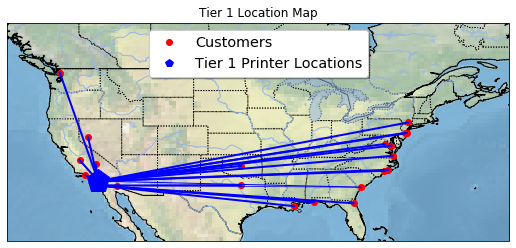

<Picture 'Tier 1 Location Map' in <Sheet [3DPrintingFacilityLocation.xlsx]Map1>>

In [12]:
# Import necessary plotting modules
import cartopy
import matplotlib.pyplot as plt

# Create a figure for tier 1 information that contains a Continental US map
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.stock_img()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.STATES, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-130, -60, 25, 50])  # Continental US Only

# Plot the customer locations with red circles
ax.plot(longs, lats,'ro', label='Customers')

# Loop over entries in overall_coords related to tier 1
for i in range(len(overall_coords[('tier1', 'longs')])):
    # Plot the locations that have > 0 printers with blue pentagons
    # Note that the sizes of the pentagons increase as the number or printers
    # at that location increase
    ax.plot(overall_coords[('tier1', 'longs')][i], overall_coords[('tier1', 'lats')][i],
            'bp', ms=(overall_coords[('tier1', 'NumberOfPrinters')][i] * 0.8) + 2)

# Plot locations that have > 0 printers with "default size" blue pentagons again
# so that a single "default size" blue pentagon will appear in the graph legend
# for Tier 1 Printer Locations
ax.plot(overall_coords[('tier1', 'longs')], overall_coords[('tier1', 'lats')],
        'bp', ms=8, label='Tier 1 Printer Locations')

# Now plot connections that exist between customers and printers based on the
# amount of satisfaction
longsconnect = []
latsconnect = []
for i in model.I:
    for j in model.J:
        # First check to see if the amount of satisfaction is "significant"
        # Ideally we would say != 0 here, but then we get "noise" solutions based
        # on numerical precision issues where the amount of satisfaction is
        # essentially zero, but NOT actually zero
        if model.SAT1[i,j].value > 0.000001:

            # Look up the longitudes for the connected locations and put them in a list
            longsconnect = [longs[customers.index(i)], longs[customers.index(j)]]

            # Look up the latitudes for the connected locations and put them in a list
            latsconnect = [lats[customers.index(i)], lats[customers.index(j)]]

            # Check the amount of satisfaction provided from the printer
            # location to the customer
            # If the amount of satisfaction is >= 75% we connect those
            # locations with a "thick" blue solid line
            if model.SAT1[i,j].value >= 0.75:
                ax.plot(longsconnect, latsconnect, 'b-', linewidth=2)

            # If the amount of satisfaction is >= 50% we connect those
            # locations with a "less thick" blue solid line
            elif model.SAT1[i,j].value >= 0.5:
                ax.plot(longsconnect, latsconnect, 'b-', linewidth=1)

            # If the amount of satisfaction is >= 25% we connect those
            # locations with an "even less thick" blue solid line
            elif model.SAT1[i,j].value >= 0.25:
                ax.plot(longsconnect, latsconnect, 'b-', linewidth=0.75)

            # If the amount of satisfaction is < 25% we connect those locations
            # with an "even less thick" blue dashed line.
            else:
                ax.plot(longsconnect, latsconnect, 'b--', linewidth=0.75)

            # Here we "empty" the two lists longsconnect and latsconntect
            # to be ready for the next pairing of customer to printer
            longsconnect = []
            latsconnect = []

# Add an overall title to the figure
ax.set_title('Tier 1 Location Map')

# Add a legend that appears in the upper center of the figure
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Plot the figure on the output terminal
plt.show()

# Worksheet where figure will go in the Excel file
smap1 = wb.sheets['Map1']

# Count how many pictures are currently on the Map1 worksheet
num_pics = smap1.pictures.count

# Loop over the number of pictures currently on the Map1 worksheet
for i in range(num_pics):
    # Name the pictures that are currently on the Map1 worksheet 1 at a time
    pic_name = smap1.pictures[i].name

    # Delete any exsisting images on the Map1 worksheet 1 at a time
    smap1.pictures[pic_name].delete()

# Write figure to Excel worksheet
smap1.pictures.add(fig, name='Tier 1 Location Map', update=True)

### Graphical representation of tier 2 printers

<div class="alert alert-block alert-warning">
<h3>Problem 8</h3>

Using the code above for tier 1 as a model, write code that produces a graphical representation of the optimal solution for tier 2 printers.  Key features of the graphical output should include the following:

- A map of the continential U.S. with state borders, rivers, and lakes
- Customer locations plotted with red circles
- Printer locations plotted with <b>green squares</b> that increase in size as the number of printers at the location increase
- A legend to indicate the meaning of the different color markers
- Lines with different thickness levels between customers and printers to indicate the level of satisfaction provided 

Your code should create figures in Jupyter and the <b>Map2</b> worksheet in Excel.
</div>

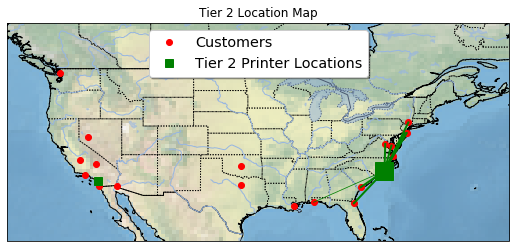

<Picture 'Tier 2 Location Map' in <Sheet [3DPrintingFacilityLocation.xlsx]Map2>>

In [13]:
# SOLUTION
# Create a figure for tier 2 information that contains a Continental US map
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.stock_img()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.STATES, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-130, -60, 25, 50])  # Continental US Only

# Plot the customer locations with red circles
ax.plot(longs, lats, 'ro', label='Customers')

# Loop over entries in overall_coords related to tier 2
for i in range(len(overall_coords[('tier2', 'longs')])):
    # Plot the locations that have > 0 printers with green squares
    # Note that the sizes of the squares increase as the number or printers
    # at that location increase.
    ax.plot(overall_coords[('tier2', 'longs')][i], overall_coords[('tier2', 'lats')][i],
            'gs', ms=(overall_coords[('tier2','NumberOfPrinters')][i] * 0.8) + 2)

# Plot locations that have > 0 printers with "default size" green squares again
# so that a single "default size" green square will appear in the graph legend
# for Tier 2 Printer Locations
ax.plot(overall_coords[('tier2', 'longs')], overall_coords[('tier2','lats')],
        'gs', ms=8, label='Tier 2 Printer Locations')

# Now plot connections that exist between customers and printers based on the amount of satisfaction.
longsconnect = []
latsconnect = []
for i in model.I:
    for j in model.J:
        # First check to see if the amount of satisfaction is "significant"
        # Ideally we would say != 0 here, but then we get "noise" solutions based
        # on numerical precision issues where the amount of satisfaction is
        # essentially zero, but NOT actually zero.
        if model.SAT2[i,j].value > 0.000001:

            # Look up the longitudes for the connected locations and puts them in a list
            longsconnect = [longs[customers.index(i)], longs[customers.index(j)]]

            # Look up the latitudes for the connected locations and put them in a list
            latsconnect = [lats[customers.index(i)], lats[customers.index(j)]]

            # Check the amount of satisfaction provided from the printer
            # location to the customer
            # If the amount of satisfaction is >= 75% we connect those
            # locations with a "thick" green solid line.
            if model.SAT2[i,j].value >= 0.75:
                ax.plot(longsconnect, latsconnect, 'g-', linewidth=2)

            # If the amount of satisfaction is >= 50% we connect those
            # locations with a "less thick" green solid line.
            elif model.SAT2[i,j].value >= 0.5:
                ax.plot(longsconnect, latsconnect, 'g-', linewidth=1)

            # If the amount of satisfaction is >= 25% we connect those locations
            # with an "even less thick" green solid line.
            elif model.SAT2[i,j].value >= 0.25:
                ax.plot(longsconnect, latsconnect, 'g-', linewidth=0.75)

            # If the amount of satisfaction is < 25% we connect those locations
            # with an "even less thick" green dashed line.
            else:
                ax.plot(longsconnect, latsconnect, 'g--', linewidth=0.75)

            # Here we "empty" the two lists longsconnect and latsconntect to be
            # ready for the next pairing of customer to printer
            longsconnect = []
            latsconnect = []

# Add an overall title to the figure
ax.set_title('Tier 2 Location Map')

# Add a legend that appears in the upper center of the figure
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Plot the figure on the output terminal
plt.show()

# Name of worksheet where figure will go in the Excel file
smap2 = wb.sheets['Map2']

# Count how many pictures are currently on the Map2 worksheet
num_pics = smap2.pictures.count

# Loop over the number of pictures currently on the Map2 worksheet
for i in range(num_pics):
    # Name the pictures that are currently on the Map2 worksheet 1 at a time
    pic_name = smap2.pictures[i].name

    # Delete any exsisting images on the Map2 worksheet 1 at a time
    smap2.pictures[pic_name].delete()

# Write figure to Excel worksheet
smap2.pictures.add(fig, name='Tier 2 Location Map', update=True)